In [1]:
# PIL 라이브러리가 설치되어 있지 않다면 설치
!pip install pillow   

from PIL import Image
import glob

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random

seed_value = 1357
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat import v1 as tf_v1
session_conf = tf_v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf_v1.Session(graph=tf_v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path_list = list()
dataset_type = 'train_full'
dataset_dir = ['paper', 'rock', 'scissors']
base_dir = os.getcwd()
for dir_name in dataset_dir:
    image_dir_path_list.append(base_dir + f"/{dataset_type}/" + dir_name)
    
print("이미지 디렉토리 경로: ", image_dir_path_list)

image_counts = 0
for image_path in image_dir_path_list:
    images=glob.glob(image_path + "/*.jpg")  

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img,"JPEG")
        image_counts += 1

    print(f"{image_path.split('/')[-1]} 이미지 resize 완료!")

이미지 디렉토리 경로:  ['/home/aiffel0049/aiffel/Exploration/1.rock_scissor_paper/train_full/paper', '/home/aiffel0049/aiffel/Exploration/1.rock_scissor_paper/train_full/rock', '/home/aiffel0049/aiffel/Exploration/1.rock_scissor_paper/train_full/scissors']
paper 이미지 resize 완료!
rock 이미지 resize 완료!
scissors 이미지 resize 완료!


In [4]:
img_size=28
color=3
def load_data(img_path_list):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=image_counts   # 가위바위보 이미지 개수 총합에 주의하세요.
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for i, img_path in enumerate(img_path_list):
        for file in glob.iglob(img_path+'/*.jpg'):
            img = np.array(Image.open(file),dtype=np.int32)
            imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
            labels[idx]=i   # 가위 : 0
            idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

(x_train, y_train)=load_data(image_dir_path_list)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
x_train_resh = x_train_norm.reshape(-1, img_size, img_size, color)

print("x_train_resh shape: {}".format(x_train_resh.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 6300 입니다.
x_train_resh shape: (6300, 28, 28, 3)
y_train shape: (6300,)


라벨:  0


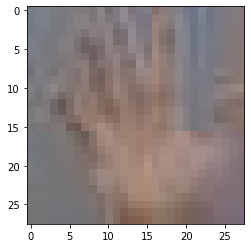

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x_train_norm[0])
print('라벨: ', y_train[0])

In [6]:
use_policy = False
if use_policy:
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    
    train_datagen = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'nearest'
    )
    
    train_datagen.fit(x_train_norm)

test_image_dir_path_list = list()
for dir_name in dataset_dir:
    test_image_dir_path_list.append(base_dir + "/test/" + dir_name)

img_size=28
color=3
def load_test_data(img_path_list):
    # 보 : 0, 바위 : 1, 가위 : 2
    number_of_data=300   # 가위바위보 이미지 개수 총합에 주의하세요.
    #이미지 데이터와 라벨(보 : 0, 바위 : 1, 가위 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for i, img_path in enumerate(img_path_list):
        for file in glob.iglob(img_path+'/*.jpg'):
            img = np.array(Image.open(file),dtype=np.int32)
            imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
            labels[idx]=i   # 보 : 0, 바위 : 1, 가위 : 2
            idx=idx+1

    print("평가데이터(x_test)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

(x_test, y_test)=load_test_data(test_image_dir_path_list)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
x_test_resh = x_test_norm.reshape(-1, img_size, img_size, color)

print("x_test_resh shape: {}".format(x_test_resh.shape))
print("y_test shape: {}".format(y_test.shape))

평가데이터(x_test)의 이미지 개수는 300 입니다.
x_test_resh shape: (300, 28, 28, 3)
y_test shape: (300,)


In [7]:
channel_1 = 16
channel_2 = 32
dense_channel_1 = 32
dense_channel_2 = 16
dropout = [0.2, 0.2]
total_class = 3
batch_size = 128
epoch = 20

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, ReLU, Flatten, Dropout, Dense

model=Sequential()
model.add(Conv2D(channel_1, (3,3), input_shape=(28,28,3)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D(2,2))
model.add(Conv2D(channel_2, (3,3)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(dense_channel_1, activation='relu'))
model.add(Dropout(dropout[0], seed=seed_value))
# model.add(keras.layers.Dense(dense_channel_2, activation='relu'))
# model.add(keras.layers.Dropout(dropout[1], seed=seed_value))
model.add(Dense(total_class, activation='softmax'))

model.summary()

model.compile(keras.optimizers.Adam(decay=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

if use_policy:
    model.fit(train_datagen.flow(x_train_resh, y_train, batch_size=batch_size),
              steps_per_epoch=len(x_train_resh) / batch_size, epochs=epoch)
else:
    model.fit(x_train_resh, y_train, epochs=epoch)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        64        
_________________________________________________________________
re_lu (ReLU)                 (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 11, 11, 32)        0

In [8]:
test_loss, test_accuracy = model.evaluate(x_test_resh, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 1s - loss: 7.3445 - accuracy: 0.5100
test_loss: 7.344494819641113 
test_accuracy: 0.5099999904632568


## Experiment Result

## - 모든 학습데이터 진행

### 1. 기본

<code>channel_1 = 16
channel_2 = 32
dense_channel_1 = 32
total_class = 3
epoch = 10</code>

<code>10/10 - 2s - loss: 13.3738 - accuracy: 0.4433
test_loss: 13.373815536499023 
test_accuracy: 0.44333332777023315</code>

0.4433, 0.3800

### 2. ImageDataGenerator 이용 / batch_size=128 / epoch=50

channel_1 = 16
channel_2 = 32
dense_channel_1 = 32
total_class = 3
batch_size = 128
epoch = 50

<code>train_datagen = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest'
    )</code>

<code>10/10 - 0s - loss: 4.9295 - accuracy: 0.3100
test_loss: 4.929497241973877 
test_accuracy: 0.3100000023841858</code>

### 3. x_train 대신, x_train_norm(지금까지 사용 안함...), vertical_flip=True 추가

<code>train_datagen = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'nearest'
    )</code>

<code>10/10 - 0s - loss: 373.8586 - accuracy: 0.4867
test_loss: 373.8586120605469 
test_accuracy: 0.4866666793823242</code>

### 4. x_train_norm과 x_test대신, x_train_resh, x_test_resh 사용

<code>10/10 - 0s - loss: 3.4082 - accuracy: 0.4300
test_loss: 3.408247709274292 
test_accuracy: 0.4300000071525574</code>

### 5. dropout=0.2 추가 (Dense위에)

<code>10/10 - 0s - loss: 2.2492 - accuracy: 0.3600
test_loss: 2.2491703033447266 
test_accuracy: 0.36000001430511475</code>

### 6. BatchNormalization 추가 (Conv2D 밑에)

<code>10/10 - 0s - loss: 4.4288 - accuracy: 0.3633
test_loss: 4.428811550140381 
test_accuracy: 0.3633333444595337</code>

### 7. dropout 위치 이동 (Dense 밑에)

epoch=50

<code>10/10 - 0s - loss: 2.4416 - accuracy: 0.4267
test_loss: 2.4416098594665527 
test_accuracy: 0.4266666769981384</code>

epoch=100

<code>10/10 - 0s - loss: 4.7021 - accuracy: 0.4133
test_loss: 4.702084541320801 
test_accuracy: 0.41333332657814026</code>

### 8. generator 제거 / optimizer에 weight decay=1e-3추가

epoch=20

<code>10/10 - 0s - loss: 10.8282 - accuracy: 0.5133
test_loss: 10.828228950500488 
test_accuracy: 0.5133333206176758</code>



## - 내가 만든 데이터로 진행

### 1. 기본

<code>channel_1 = 16
channel_2 = 32
dense_channel_1 = 32
dense_channel_2 = 16
total_class = 3
epoch = 10</code>

<code>10/10 - 0s - loss: 9.2919 - accuracy: 0.2867
test_loss: 9.29186725616455 
test_accuracy: 0.2866666615009308
</code>
0.46, 0.4433, 0.39, 0.46, 0.4333

### 2. dropout 2개 추가 / epoch=100

<code>channel_1 = 16
channel_2 = 32
dense_channel_1 = 32
dropout = [0.2, 0.2]
total_class = 3
epoch = 100</code>

<code>10/10 - 0s - loss: 7.6417 - accuracy: 0.4300
test_loss: 7.641697406768799 
test_accuracy: 0.4300000071525574</code>

0.3, 0.33, 0.36, 0.4533, 0.3433

### 3. dropout 1개 추가 / epoch=100

<code>channel_1 = 16
channel_2 = 32
dense_channel_1 = 32
dropout = [0.2]
total_class = 3
epoch = 100</code>

<code>10/10 - 0s - loss: 10.6041 - accuracy: 0.4000
test_loss: 10.604056358337402 
test_accuracy: 0.4000000059604645</code>

0.4, 0.4867, 0.38, 0.5767, 0.3267

### 4. dropout 1개 추가 / channel 변경 / epoch=50

<code>channel_1 = 24
channel_2 = 48
dense_channel_1 = 48
dropout = [0.2]
total_class = 3
epoch = 50</code>

<code>10/10 - 0s - loss: 7.5475 - accuracy: 0.3800
test_loss: 7.5474748611450195 
test_accuracy: 0.3799999952316284</code>

0.38, 0.4267, 0.4933, 0.4367, 0.3467

### 4. dropout 1개 추가 / channel 변경 / epoch=50

<code>channel_1 = 24
channel_2 = 48
dense_channel_1 = 48
dropout = [0.2]
total_class = 3
epoch = 50</code>

<code>10/10 - 0s - loss: 7.5475 - accuracy: 0.3800
test_loss: 7.5474748611450195 
test_accuracy: 0.3799999952316284</code>

0.38, 0.4267, 0.4933, 0.4367, 0.3467

### 5. dropout 2개 추가 / channel 변경 / Dense 하나 추가 / epoch=50

<code>channel_1 = 24
channel_2 = 48
dense_channel_1 = 48
dropout = [0.2]
total_class = 3
epoch = 50</code>

<code>10/10 - 0s - loss: 7.5475 - accuracy: 0.3800
test_loss: 7.5474748611450195 
test_accuracy: 0.3799999952316284</code>

0.38, 0.4267, 0.4933, 0.4367, 0.3467

### 6. dropout 2개 추가 / channel 변경 2 / Dense 하나 추가 / epoch=50

<code>channel_1 = 32
channel_2 = 64
dense_channel_1 = 64
dense_channel_2 = 16
dropout = [0.2, 0.2]
total_class = 3
epoch = 50</code>

<code>10/10 - 0s - loss: 5.5355 - accuracy: 0.4900
test_loss: 5.535473346710205 
test_accuracy: 0.49000000953674316</code>

0.49, 0.3233, 0.3267, 0.3067, 0.3667